In [2]:
import numpy as np
import pandas as pd
import cv2
import os
from google.colab.patches import cv2_imshow

ROOT_DIRECTORY = "/content/drive/MyDrive/clouds/"
DATASET_DIRECTORY = "CCSN dataset/"

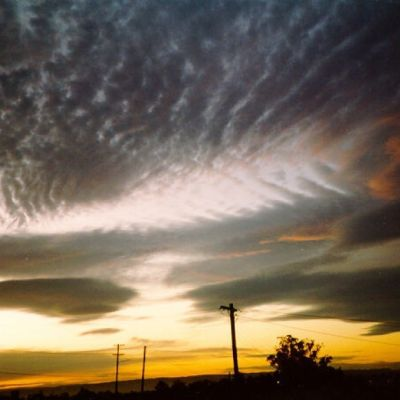

In [3]:
img = cv2.imread("/content/drive/MyDrive/clouds/CCSN dataset/Ac/Ac-N001.jpg")
cv2_imshow(img)
# k = cv2.waitKey(0)

## Dataset info

In [7]:
f"{ROOT_DIRECTORY}/{DATASET_DIRECTORY}"
os.getcwd()

'/content'

### How many images are there?

In [4]:
dataset_subdirectory_list = os.listdir(f"{ROOT_DIRECTORY}/{DATASET_DIRECTORY}")
dataset_subdirectory_list.remove(".DS_Store")

class_size_dict = {}

for subdir in dataset_subdirectory_list:
    num_images = len(os.listdir(f"{ROOT_DIRECTORY}/{DATASET_DIRECTORY}/{subdir}"))
    class_size_dict[subdir] = num_images

total_num_images = sum([class_size_dict[subdir] for subdir in dataset_subdirectory_list])

print("Class sizes:")
print(class_size_dict)
print()
print(f"Total number of images: {total_num_images}")

Class sizes:
{'Ct': 200, 'Ac': 221, 'Ns': 274, 'Cu': 182, 'Ci': 139, 'St': 202, 'Sc': 340, 'As': 188, 'Cs': 287, 'Cc': 268, 'Cb': 242}

Total number of images: 2543


### What are the dimensions of the images?

In [ ]:
image_size_dict = {}

for subdir in dataset_subdirectory_list:
    image_fname_list = os.listdir(f"{ROOT_DIRECTORY}/{DATASET_DIRECTORY}/{subdir}")
    for fname in image_fname_list:
        img = cv2.imread(f"{ROOT_DIRECTORY}/{DATASET_DIRECTORY}/{subdir}/{fname}")
        if img.shape not in image_size_dict.keys():
            image_size_dict[img.shape] = 1
        else:
            image_size_dict[img.shape] += 1

print(image_size_dict)

{(400, 400, 3): 2332, (256, 256, 3): 211}


That's annoying. It looks like the images should all be 400x400 but there's a non-negligible amount that isn't. Are those images at least from the same class, or distributed evenly across the class? Let's figure out.

In [ ]:
class_size_256_dict = {}

for subdir in dataset_subdirectory_list:
    class_size_256_dict[subdir] = 0
    image_fname_list = os.listdir(f"{ROOT_DIRECTORY}/{DATASET_DIRECTORY}/{subdir}")
    for fname in image_fname_list:
        img = cv2.imread(f"{ROOT_DIRECTORY}/{DATASET_DIRECTORY}/{subdir}/{fname}")
        if img.shape == (256, 256, 3):
            class_size_256_dict[subdir] += 1

print("Here's the distribution of images sized 256x256 by class:")
class_size_256_dict

Here's the distribution of images sized 256x256 by class:


{'Ct': 0,
 'Ac': 0,
 'Ns': 74,
 'Cu': 0,
 'Ci': 0,
 'St': 0,
 'Sc': 0,
 'As': 0,
 'Cs': 47,
 'Cc': 90,
 'Cb': 0}

When we build out a neural net, we need to input size to be standardized. So, for the minority of images that are shaped 256x256, we will upscale them to 400x400. The upscaled images will probably not be the same quality as the ones already sized 400x400, so this is a limitation we will have to take into account.

### What is the image quality like?

Took a look at a few images from each class. Quality is ok, nothing amazing. Can distinguish the textures in clouds. Occasionally photos are a little grainy. The only concern is for some wispy clouds, notably Ci, image compression artifacts could be mistaken for cloud texture.

## Data format

### What are the image formats? Are they all the same?

In [ ]:
image_format_count_dict = {}

dataset_path = f"{ROOT_DIRECTORY}/{DATASET_DIRECTORY}"
for subdir in dataset_subdirectory_list:
    image_filename_list = os.listdir(f"{dataset_path}/{subdir}")
    for fname in image_filename_list:
        image_format = fname[-3:]
        if image_format in image_format_count_dict.keys():
            image_format_count_dict[image_format] += 1
        else:
            image_format_count_dict[image_format] = 1

print("Image format distribution:")
image_format_count_dict

Image format distribution:


{'jpg': 2543}

Constistency is good.

In [ ]:
"catdog"[-3:]

'dog'

### Are there any corrupted files?

Since some of the previous cells ran cv2.imread() followed by img.shape with no errors, we can safely conclude there are no corrupt images. Otherwise running img.shape would have returned an error since cv2.imread() would give a NoneType.

## Classes

### How many classes are there? How are they balanced?

In [ ]:
class_prop_dict = {}
for k in class_size_dict.keys():
    class_prop_dict[k] = class_size_dict[k]/total_num_images
print("Proportional breakdown of class sizes:")
print(class_prop_dict)

Proportional breakdown of class sizes:
{'Ct': 0.07864726700747149, 'Ac': 0.086905230043256, 'Ns': 0.10774675580023595, 'Cu': 0.07156901297679906, 'Ci': 0.05465985057019269, 'St': 0.0794337396775462, 'Sc': 0.13370035391270155, 'As': 0.0739284309870232, 'Cs': 0.11285882815572158, 'Cc': 0.1053873377900118, 'Cb': 0.0951631930790405}


Most class sizes hover around 8 or 9% of the total dataset size. The smallest class, Ci, makes up 5.4% of the data, and the largest class, Sc, makes up 13.3% of the data. Classes are relatively balanced; I don't think we need to worry too much about stratification or relying on F1 score.

## TODO Inspecting images

### What are the image compositions? What other things are in the images besides clouds?

| Class | Image descriptions |
| ----- | ------------------ |
| Ac | Mostly landscape shots that mostly show the sky but cover some ground. A few shots of just the sky. There was a shot from *above* the clouds, on a plane. The portions of ground usually have a distinct color/boundary from the sky. |
| As | Shots from the ground. A few purely sky shots, mostly shots with some ground in the foreground. A couple shots with water or something else ahead/below the ground edge, producing another edge in what would otherwise be a solid black chunk of e.g. trees in the sunset.
| Cb | Cloud tend to cover most or all of the sky. Lightning sometimes. Didn't see any pure sky shots from my sample.
| Cc | Majority sky shots from my sample. Otherwise the usual foreground with ground or water. Mix of 400x400 and 256x256 shots. Saw a photo where a foreground object, a tree, extends all the way to the top of the image. Something to consider.

### Describe the clouds from each class. How are the hues, saturation, and brightness? Internally, are there varying textures or large flat spaces? Are edges rough or smooth? Do any of these observations correlate with each other? E.g. smooth edges in dark images, or flat textures on white clouds.

| Class | Colors | Textures | Edges | Notes |
| ----- | ------ | -------- | ----- | ----- |
| Ac | Mix of whites, greys, and warmth from sunsets. | Wavy textures like gravity waves | Usually complex edges unless the clouds are flat inside |  |
| As | A lot of sunset colors giving red, orange yellow. Some blue sky/white clouds, some grey clouds | Generally flat textures | Fuzzy/complex edges | Sunset shots are especially flat looking
| Cb | Lots of gray. Dark or muted shots | Mix of flat textures, usually at the bottom of the clouds, and complex fluffy textures higher up, mostly pronounced in brighter shots. | Boundaries are pretty clear due to better contrast and more solid cloud structure |
Cc |  Mostly white/blue. Can be bright or slightly muted. | Ripple textures are very common. | Edges are usually hard to discern because of the wispy structure. |


## Conclusion

1. During training or inference, include a check for images that are not sized 400x400 and upscale them before inputting them to the model. Keep an eye out for worse performance coming from Ns, Cs, or Cc classes, since these have significant proportion of images that will be upscaled.
2. Image compression artifacts may an issue for classes with wispy clouds, like Ci.
3. Class distribution is well balanced. Don't need to worry about skewed class size.